## Dynamic Traffic Assignments: DUO, DUE, DSO


There are 3 famous route choice principles for dynamic traffic assignments (DTA) (the definition varies depending on the terminology).

- Dynamic User Optimal (DUO): Travelers choose the shortest path based on the instantaneous travel time (the current average speed). 
- Dynamic User Equilibrium (DUE): Travelers choose the shortest path based on the actual travel time. 
- Dynamic System Optimal (DSO): Travelers choose the path so that the total travel time is minimized.

The important point of DTA is that travel time may change as the time progresses. 
Therefore, in the DUO, the chosen route may turn out not to be the actual shortest path after the traveler completes their trip, as the travel time may change during their trip.
Similarly, in the DUE, the "actual travel time" is unknown when the traveler choose the route, as it depends on the future travel time.
Likewise, in the DSO, it is not obvious which path minimizes the total travel time.

The default routing principle of UXsim is based on DUO, because it is reasonable and very easy to compute.

DUE and DSO are also important as theoretical benchmarks. 
Due to the aforementioned complexity, it is known that they are difficult to solve especially when the network is large. 
But, for small or mid scale networks with relatively small number of platoons, their approximate solutions can be obtained by UXsim. 
The solvers for DTA problems are implemented as `uxsim.DTAsolvers` submodule.
In this notebook, we demonstrate their behaviors.

Techical notes for experienced readers.
In this demonstration, we consider the route choice problem only. In the other words, we do not consider the departure time problem, and the departure time of each traveler is assumed to be fixed.


In [ ]:
import pandas as pd
from pylab import *
import uxsim
from uxsim.DTAsolvers import *

### Two route network with parallel highway and arterial

We simulate a simple toy network with a route choice option. In order to use the identical scenario in multiple simulations efficiently, we define the following function that setup a World object with the identical conditions.

In [2]:
# scenario definition
def create_World():
    """
    A function that returns World object with scenario informaiton. This is faster way to reuse the same scenario, as `World.copy` or `World.load_scenario` takes some computation time.
    """
    W = uxsim.World(
        name="",
        deltan=20,
        tmax=6000,
        print_mode=0, save_mode=1, show_mode=1,
        vehicle_logging_timestep_interval=1, 
        hard_deterministic_mode=False,
        random_seed=42
    )

    W.addNode("1", 0, 1)
    W.addNode("2", 1, 1)
    W.addNode("3", 5, 1)
    W.addNode("4", 0, 0)
    W.addNode("5", 1, 0)
    W.addNode("6", 5, 0)
    W.addNode("7", 6, 0.5)

    W.addLink("highway12", "1", "2", length=1000, number_of_lanes=1, merge_priority=1)
    W.addLink("highway23", "2", "3", length=3000, number_of_lanes=1, merge_priority=1, capacity_out=0.6)
    W.addLink("highway37", "3", "7", length=1000, number_of_lanes=1, merge_priority=1)
    W.addLink("onramp", "5", "2", length=1000, number_of_lanes=1, merge_priority=0.5)
    W.addLink("arterial45", "4", "5", length=1000, free_flow_speed=10, number_of_lanes=2, merge_priority=0.5)
    W.addLink("arterial56", "5", "6", length=3000, free_flow_speed=10, number_of_lanes=2, merge_priority=0.5)
    W.addLink("arterial67", "6", "7", length=1000, free_flow_speed=10, number_of_lanes=2, merge_priority=0.5)

    W.adddemand("1", "7", 0, 3000, 0.3)
    W.adddemand("4", "7", 0, 3000, 0.4*3)

    return W

The network structure is as follows. Vehicles travel from nodes "1" and "4" at the left to node "7" at the right. The upper route is a *highway*, and the bottom is an *arterial road*. The highway has faster maximum speed but smaller traffic capacity compared with the arterial road. 
Vehicles from "3" can choose either highway or arterial, depending on the traffic condition. 

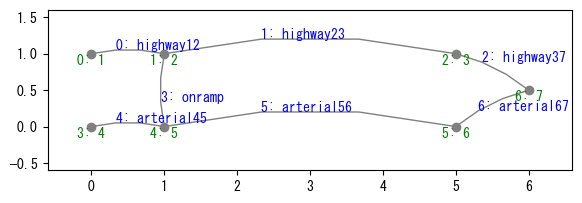

In [3]:
W = create_World()
W.show_network()

For later use, we define the following visualization function to visualize simulation results.

In [4]:
def visualizaion_helper_function(W):
    W.analyzer.print_simple_stats(force_print=True)
    W.analyzer.network_average(legend_outside=True)

    r1 = W.defRoute(["arterial45", "onramp", "highway23", "highway37"])
    r2 = W.defRoute(["arterial45", "arterial56", "arterial67"])

    W.analyzer.time_space_diagram_traj_links(r1.links)
    W.analyzer.time_space_diagram_traj_links(r2.links)

    ttt = np.linspace(0, W.TIME, W.TSIZE)
    tt1 = [r1.actual_travel_time(t) for t in ttt]
    tt2 = [r2.actual_travel_time(t) for t in ttt]

    fig, ax1 = subplots()
    ax1.plot(ttt, tt1, "--", label="r1", lw=1)
    ax1.plot(ttt, tt2, "--", label="r2", lw=1)
    ax1.set_xlabel("t")
    ax1.set_ylabel("travel time")
    ax1.grid()
    ax2 = ax1.twinx()
    ax2.set_ylabel("cumlative count")
    ax2.plot(ttt, W.get_link("onramp").cum_arrival, "-", label="highway (r1)")
    ax2.plot(ttt, W.get_link("arterial56").cum_arrival, "-", label="arterial (r2)")
    ax1.legend(loc="upper center", bbox_to_anchor=(0.1, 1.25), ncol=1)
    ax2.legend(loc="upper center", bbox_to_anchor=(0.9, 1.25), ncol=1)
    show()

#### DUO

DUO can be simulated by the default procedure of UXsim as follows.

results:
 average speed:	 9.6 m/s
 number of completed trips:	 4500 / 4500
 total travel time:		 4046400.0 s
 average travel time of trips:	 899.2 s
 average delay of trips:	 569.2 s
 delay ratio:			 0.633
 total distance traveled:	 23580000.0 m
results:
 average speed:	 9.6 m/s
 number of completed trips:	 4500 / 4500
 total travel time:		 4046400.0 s
 average travel time of trips:	 899.2 s
 average delay of trips:	 569.2 s
 delay ratio:			 0.633
 total distance traveled:	 23580000.0 m


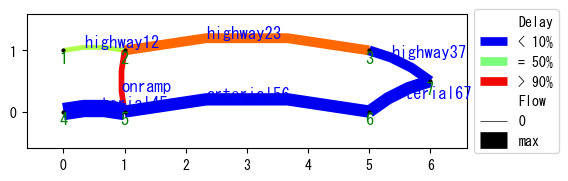

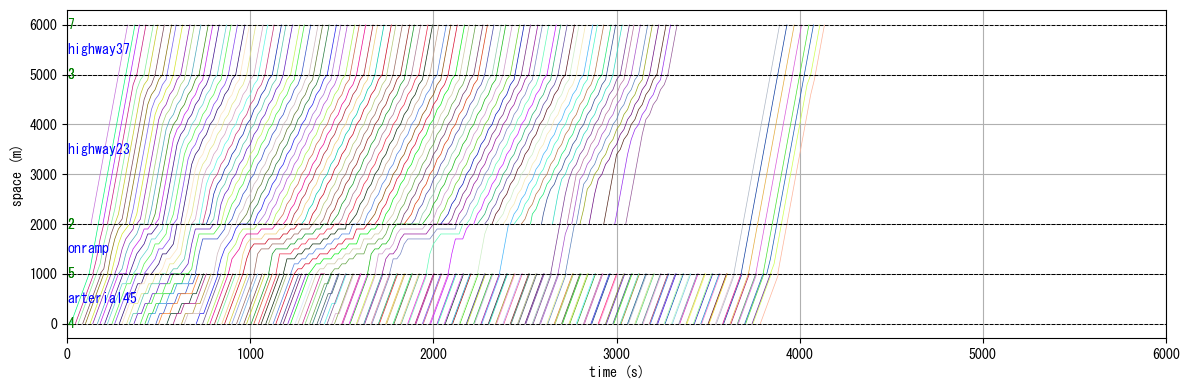

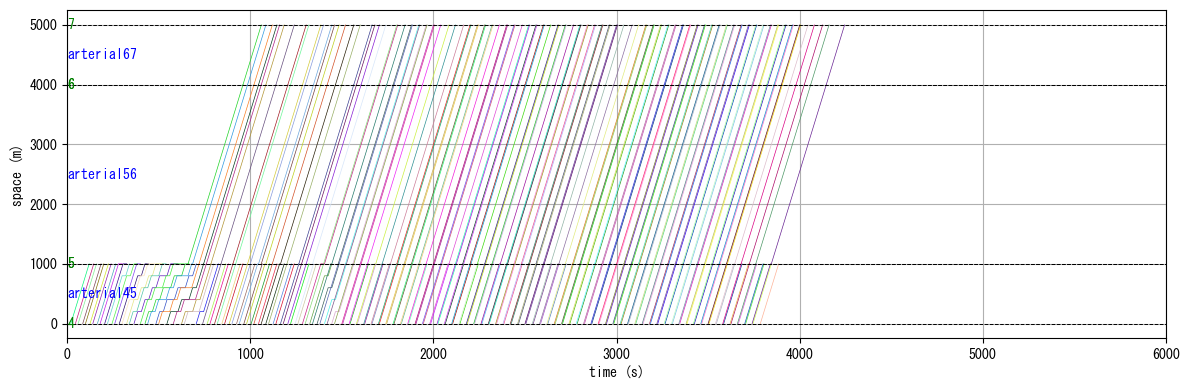

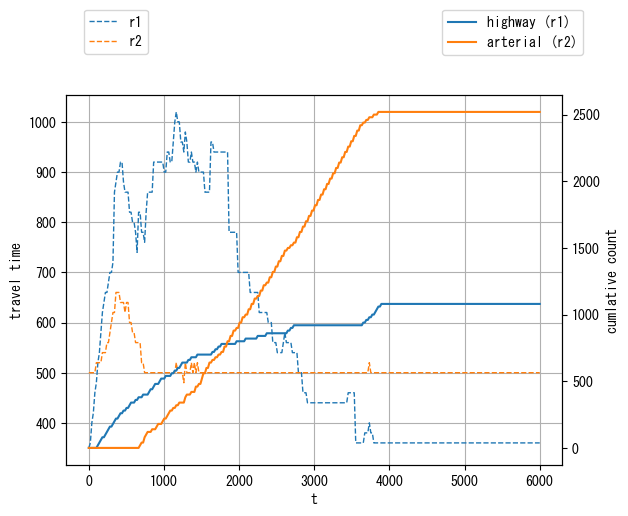

In [5]:
# DUO (default)

W_DUO = create_World()
W_DUO.exec_simulation()
W_DUO.analyzer.print_simple_stats(force_print=True)
df_DUO = W_DUO.analyzer.basic_to_pandas()

visualizaion_helper_function(W_DUO)

In DUO, you can see that many vehicles chose the highway route at the early stage of the simulation due to the fast maximum speed. It then caused a significant traffic jam, resulting a longer travel time. This demonstrates the myopic nature of DUO routing principle.

#### DUE

Approximate solution of DUE can be obtained by `SolverDUE` function as follows.
The solution is not exact as exact DUE (in which every driver chooses the route with least travel cost) is very difficult to compute.
In easy terms, the approximate DUE means that each driver chooses routes with the least expected cost when the cost is averaged for several days.

More specifically (you can skip the following explanation as it is a bit technical), this function computes a near dynamic user equilibrium state as a steady state of day-to-day dynamical routing game.
On day `i`, vehicles choose their route based on actual travel time on day `i-1` with the same departure time.
If there are shorter travel time route, they will change with probability `swap_prob`.
This process is repeated until `max_iter` day.
It is expected that this process eventually reach a steady state.
Due to the problem complexity, it does not necessarily reach or converge to Nash equilibrium or any other stationary points.
However, in the literature, it is argued that the steady state can be considered as a reasonable proxy for Nash equilibrium or dynamic equilibrium state.
There are some theoretical background for it; but intuitively speaking, the steady state can be considered as a realistic state that people's rational behavior will reach.

This method is based on the following literature:

- Ishihara, M., & Iryo, T. (2015). Dynamic Traffic Assignment by Markov Chain. Journal of Japan Society of Civil Engineers, Ser. D3 (Infrastructure Planning and Management), 71(5), I_503-I_509. (in Japanese). https://doi.org/10.2208/jscejipm.71.I_503
- Iryo, T., Urata, J., & Kawase, R. (2024). Traffic Flow Simulator and Travel Demand Simulators for Assessing Congestion on Roads After a Major Earthquake. In APPLICATION OF HIGH-PERFORMANCE COMPUTING TO EARTHQUAKE-RELATED PROBLEMS (pp. 413-447). https://doi.org/10.1142/9781800614635_0007
- Iryo, T., Watling, D., & Hazelton, M. (2024). Estimating Markov Chain Mixing Times: Convergence Rate Towards Equilibrium of a Stochastic Process Traffic Assignment Model. Transportation Science. https://doi.org/10.1287/trsc.2024.0523

In [6]:
# DUE
solver_DUE = SolverDUE(create_World)
solver_DUE.solve(max_iter=100, print_progress=False)
W_DUE = solver_DUE.W_sol
W_DUE.analyzer.print_simple_stats(force_print=True)
df_DUE = W_DUE.analyzer.basic_to_pandas()

solving DUE...
DUE summary:
 total travel time: initial 4046400.0 -> average of last 25 iters 3191056.0
 number of potential route changes: initial 1580.0 -> average of last 25 iters 1000.8
 route travel time gap: initial 57.2 -> average of last 25 iters 10.2
 computation time: 5.5 seconds
results:
 average speed:	 11.3 m/s
 number of completed trips:	 4500 / 4500
 total travel time:		 3195600.0 s
 average travel time of trips:	 710.1 s
 average delay of trips:	 380.1 s
 delay ratio:			 0.535
 total distance traveled:	 23880000.0 m


results:
 average speed:	 11.3 m/s
 number of completed trips:	 4500 / 4500
 total travel time:		 3195600.0 s
 average travel time of trips:	 710.1 s
 average delay of trips:	 380.1 s
 delay ratio:			 0.535
 total distance traveled:	 23880000.0 m


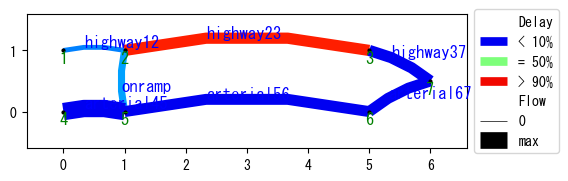

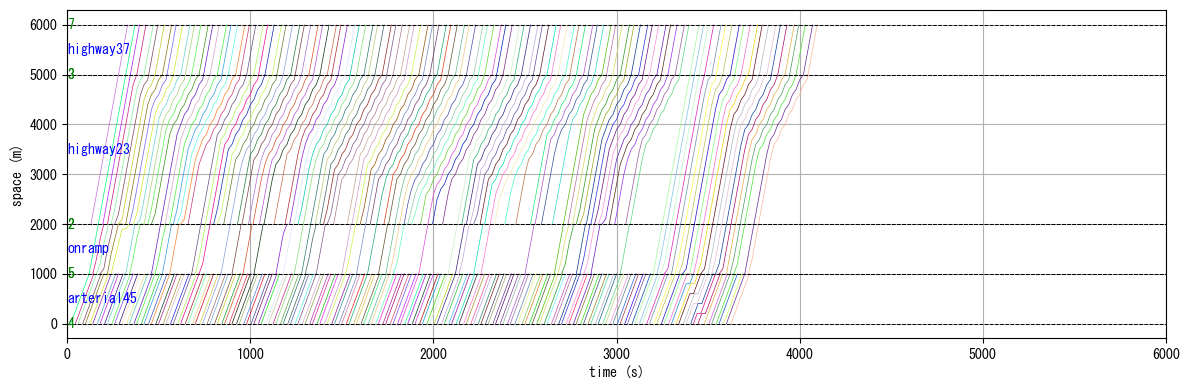

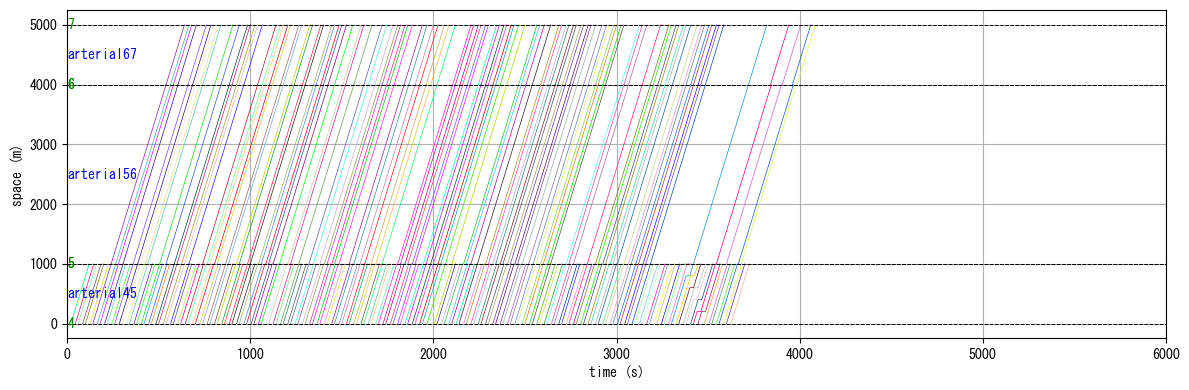

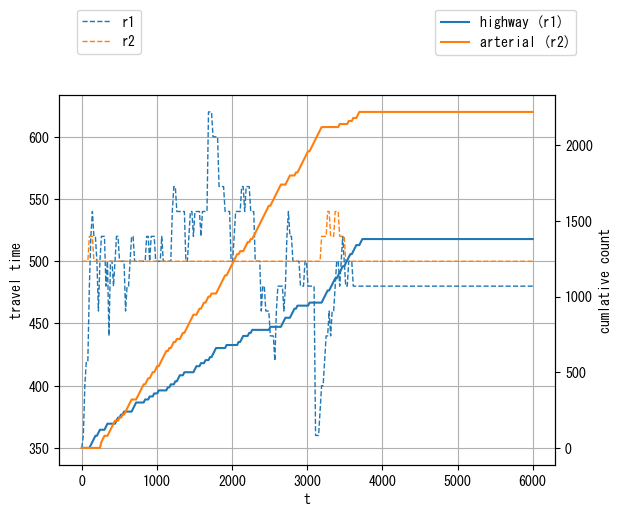

In [7]:
visualizaion_helper_function(W_DUE)

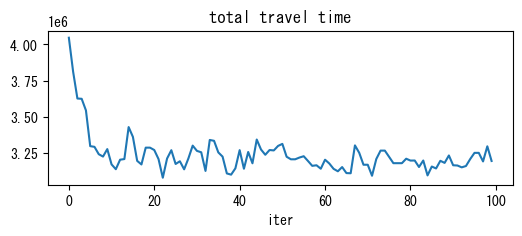

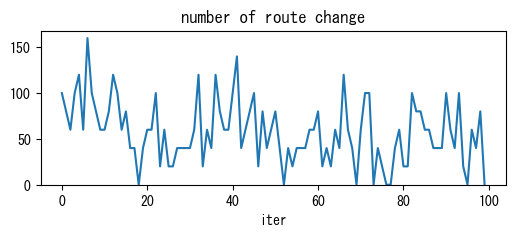

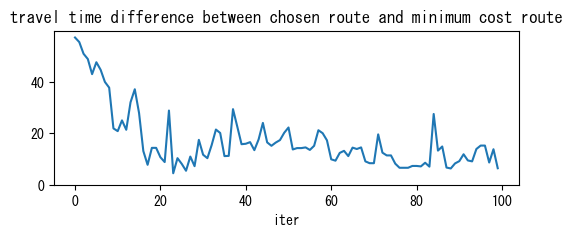

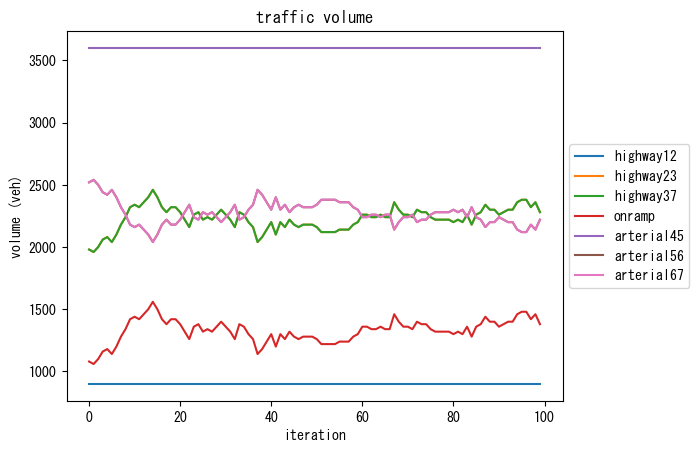

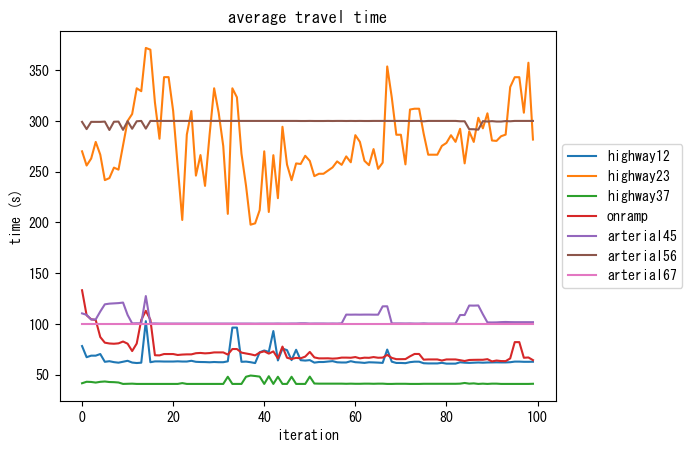

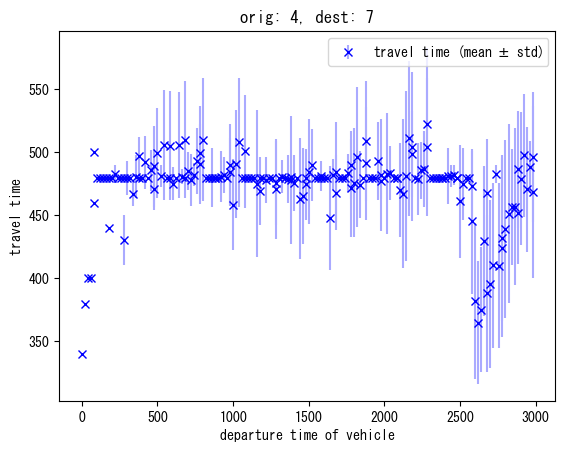

In [8]:
solver_DUE.plot_convergence()
solver_DUE.plot_link_stats()
solver_DUE.plot_vehicle_stats(orig="4", dest="7")

In DUE, you can see that cost is more balanced than DUO.
For example, the plot "travel time difference between chosen route and minimum cost route" shows that it is reduced from 60 sec in DUO (the initial solution) to 10-20 sec in the final solution.

As a result of the travelers' smart decision making, the total travel time of DUE is reduced to about 3 200 000 sec from 4 000 000 sec in the DUO where travelers are myopic. Note that these numbers may be different for each simulation as the algorithm is stochastic.

#### DSO

Now we compute DSO solution.
Here we use Adaptive Large Neighborhood Search (ALNS), which is a heuristic algorithm that is suitable for this kind of problem, customized for the DSO problem by incorporating some domain-knowledge.

The objective function for ALNS is 

    total_travel_time + simulation_duration*number_of_vehicles_that_could_not_complete_their_trip

The second term should be zero for reasonable results.

In [13]:
# DSO by ALNS
solver_DSO = SolverDSO_ALNS(create_World)
solver_DSO.solve(max_iter=300, print_progress=False)
W_DSO = solver_DSO.W_sol
W_DSO.analyzer.print_simple_stats(force_print=True)
df_DSO = W_DSO.analyzer.basic_to_pandas()


No initial solution
solving DSO by ALNS...
DSO summary:
 total travel time: initial 3144400.0 -> last 2955200.0
 computation time: 19.2 seconds
results:
 average speed:	 12.5 m/s
 number of completed trips:	 4500 / 4500
 total travel time:		 2955200.0 s
 average travel time of trips:	 656.7 s
 average delay of trips:	 326.7 s
 delay ratio:			 0.497
 total distance traveled:	 23640000.0 m


results:
 average speed:	 12.5 m/s
 number of completed trips:	 4500 / 4500
 total travel time:		 2955200.0 s
 average travel time of trips:	 656.7 s
 average delay of trips:	 326.7 s
 delay ratio:			 0.497
 total distance traveled:	 23640000.0 m


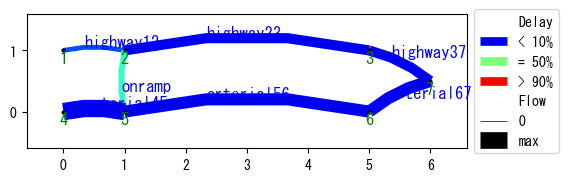

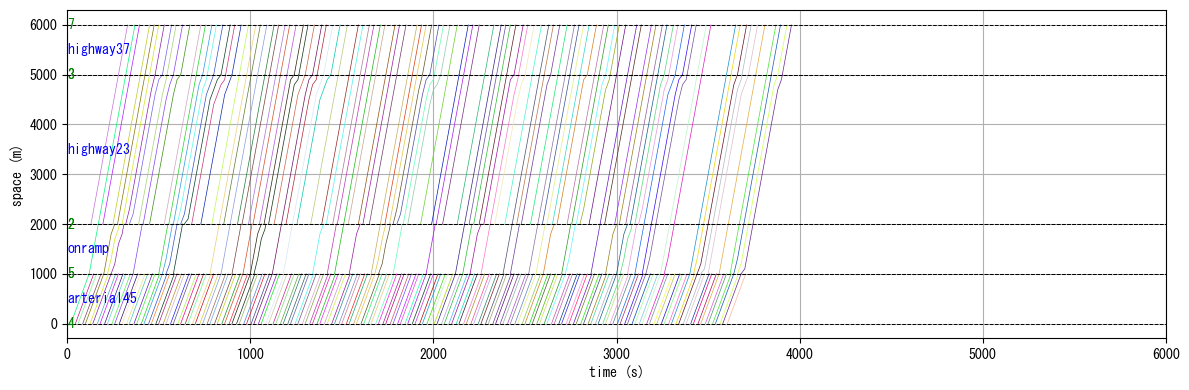

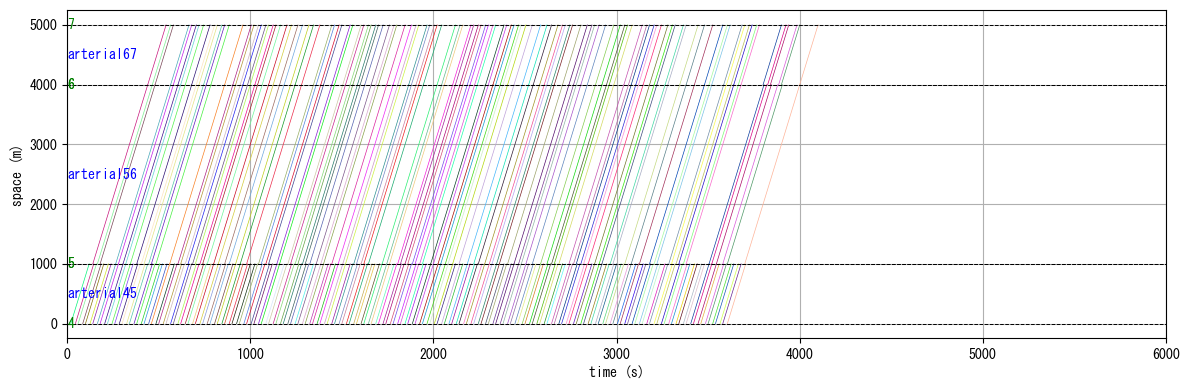

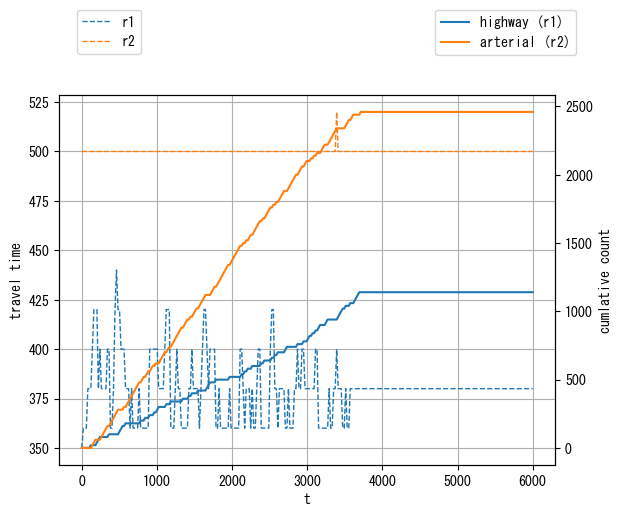

In [14]:
visualizaion_helper_function(W_DSO)

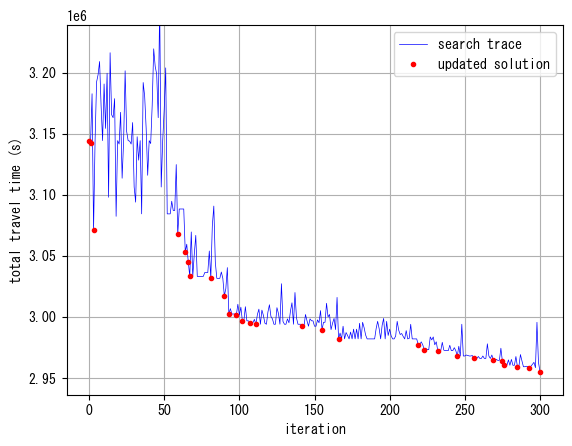

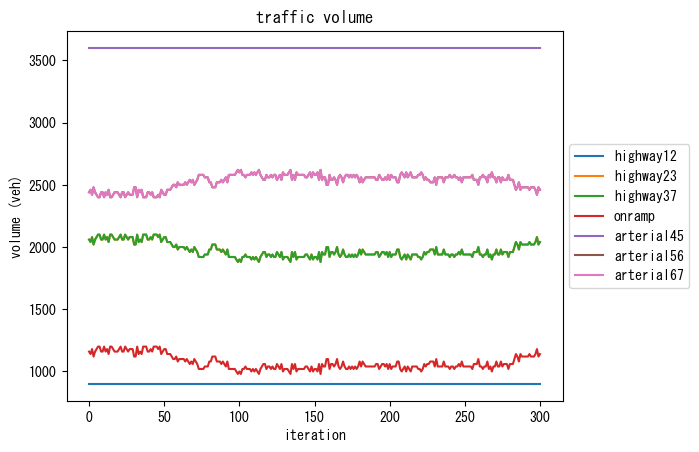

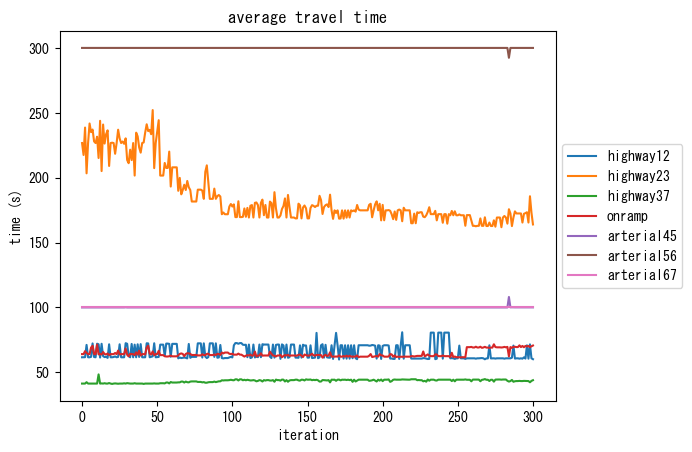

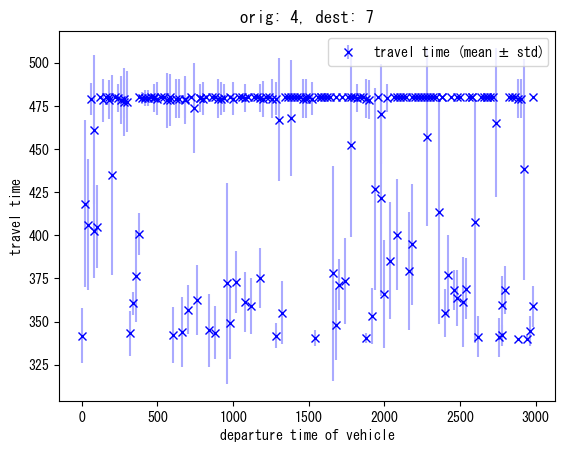

In [15]:
solver_DSO.plot_convergence()
solver_DSO.plot_link_stats()
solver_DSO.plot_vehicle_stats(orig="4", dest="7")

You can see that the congestion is almost eliminated.
The total travel time is 3 000 000 sec in DSO. 
This is more efficient than DUE (with about 3 200 000 sec) or DUO (with about 4 000 000 sec).

However, some travelers are enforced to choose routes with longer travel time to improve the efficiency of the entire system.

#### Comparison

Comparison of 3 cases.

In [ ]:
df_DUO['Name'] = 'DUO'
df_DUE['Name'] = 'DUE'
df_DSO['Name'] = 'DSO'

df_combined = pd.concat([df_DUO, df_DUE, df_DSO], ignore_index=True)
cols = ['Name'] + [col for col in df_combined.columns if col != 'Name']
df_combined = df_combined[cols]
display(df_combined)

Name  total_trips  completed_trips  total_travel_time  average_travel_time  \
0  DUO         4500             4500          4046400.0           899.200000   
1  DUE         4500             4500          3195600.0           710.133333   
2  DSO         4500             4500          2955200.0           656.711111   

   total_delay  average_delay  
0    2561400.0     569.200000  
1    1710600.0     380.133333  
2    1470200.0     326.711111

### Large-scale scenario

Now we show larger example.

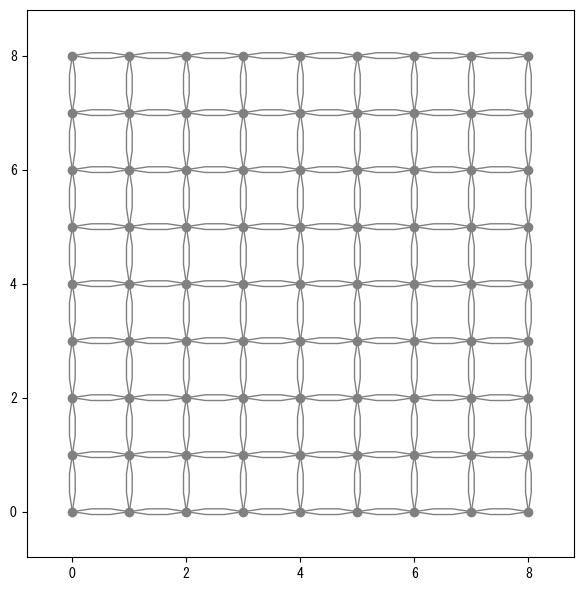

In [19]:
import uxsim
from uxsim import DTAsolvers

def create_World():
    # simulation world
    W = uxsim.World(
        name="",
        deltan=10,
        tmax=4800,
        duo_update_time=300,
        print_mode=0, save_mode=0, show_mode=1,
        random_seed=42,
    )

    # scenario
    #automated network generation
    #deploy nodes as an imax x jmax grid
    imax = 9
    jmax = 9
    id_center = 4
    nodes = {}
    for i in range(imax):
        for j in range(jmax):
            nodes[i,j] = W.addNode(f"n{(i,j)}", i, j, flow_capacity=1.6)

    #create links between neighborhood nodes
    links = {}
    for i in range(imax):
        for j in range(jmax):
            free_flow_speed = 10
            if i != imax-1:
                if j == id_center:
                    free_flow_speed = 20
                links[i,j,i+1,j] = W.addLink(f"l{(i,j,i+1,j)}", nodes[i,j], nodes[i+1,j], length=1000, free_flow_speed=free_flow_speed)
            if i != 0:
                if j == id_center:
                    free_flow_speed = 20
                links[i,j,i-1,j] = W.addLink(f"l{(i,j,i-1,j)}", nodes[i,j], nodes[i-1,j], length=1000, free_flow_speed=free_flow_speed)
            if j != jmax-1:
                if i == id_center:
                    free_flow_speed = 20
                links[i,j,i,j+1] = W.addLink(f"l{(i,j,i,j+1)}", nodes[i,j], nodes[i,j+1], length=1000, free_flow_speed=free_flow_speed)
            if j != 0:
                if i == id_center:
                    free_flow_speed = 20
                links[i,j,i,j-1] = W.addLink(f"l{(i,j,i,j-1)}", nodes[i,j], nodes[i,j-1], length=1000, free_flow_speed=free_flow_speed)

    #generate traffic demand between the boundary nodes
    demand_flow = 0.08
    demand_duration = 2400
    outer_ids = 3
    for n1 in [(0,j) for j in range(outer_ids, jmax-outer_ids)]:
        for n2 in [(imax-1,j) for j in range(outer_ids,jmax-outer_ids)]:
            W.adddemand(nodes[n1], nodes[n2], 0, demand_duration, demand_flow)
        for n2 in [(i,jmax-1) for i in range(outer_ids, imax-outer_ids)]:
            W.adddemand(nodes[n1], nodes[n2], 0, demand_duration, demand_flow)
    for n1 in [(i,0) for i in range(outer_ids, imax-outer_ids)]:
        for n2 in [(i,jmax-1) for i in range(outer_ids, imax-outer_ids)]:
            W.adddemand(nodes[n1], nodes[n2], 0, demand_duration, demand_flow)
        for n2 in [(imax-1,j) for j in range(outer_ids,jmax-outer_ids)]:
            W.adddemand(nodes[n1], nodes[n2], 0, demand_duration, demand_flow)
    
    return W

W = create_World()
W.change_print_mode(1)
W.show_network(network_font_size=0)

In this grid network, central links (links at x=4 and y=4) have faster free-flow speed of 20 m/s. The rest of links are with free-flow speed of 10 m/s. And the following four types of demands are generated:

- bottom edge (3 nodes at (3,0), (4,0), (5,0)) to top (3 nodes at (3,8), (4,8), (5,8))
- bottom edge to right
- left edge to top
- left to right

This is a deliberately inefficient setting that causes congestion. In a free-flowing condition, travelers tend to choose the central links. However, because traffic capacity of central links is limited, it may cause congestion although many other links are empty. To enhance system's performance, some travelers need to be distributed to slower links to efficiently utilize the network capacity.

#### DUO

First, let's compute DUO solution.

simulation setting:
 scenario name: 
 simulation duration:	 4800 s
 number of vehicles:	 6840 veh
 total road length:	 288000 m
 time discret. width:	 10 s
 platoon size:		 10 veh
 number of timesteps:	 480
 number of platoons:	 684
 number of links:	 288
 number of nodes:	 81
 setup time:		 5.45 s
simulating...
      time| # of vehicles| ave speed| computation time
       0 s|        0 vehs|   0.0 m/s|     0.00 s
     600 s|     1380 vehs|   9.7 m/s|     0.05 s
    1200 s|     2240 vehs|   8.5 m/s|     0.12 s
    1800 s|     2860 vehs|   8.0 m/s|     0.20 s
    2400 s|     3030 vehs|   9.4 m/s|     0.28 s
    3000 s|     1290 vehs|   7.7 m/s|     0.34 s
    3600 s|        0 vehs|   0.0 m/s|     0.37 s
    4200 s|        0 vehs|   0.0 m/s|     0.38 s
    4800 s|        0 vehs|   0.0 m/s|     0.39 s
 simulation finished
results:
 average speed:	 9.6 m/s
 number of completed trips:	 6840 / 6840
 total travel time:		 6663000.0 s
 average travel time of trips:	 974.1 s
 average delay of tr

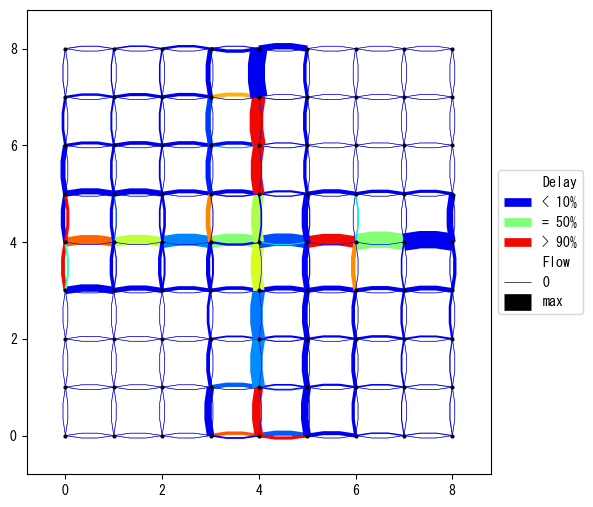

 generating animation...


100%|██████████| 60/60 [00:02<00:00, 20.86it/s]


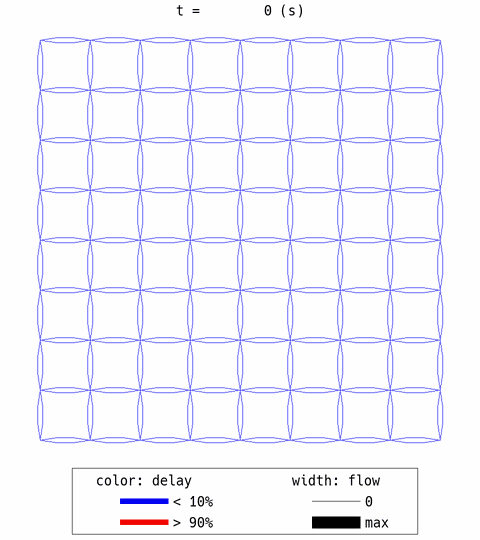

In [20]:
# execute simulation
W.exec_simulation()

# visualize
W.analyzer.print_simple_stats(force_print=True)
W.analyzer.network_average(network_font_size=0, legend=True, legend_outside=True)
W_DUO = W
df_DUO = W_DUO.analyzer.basic_to_pandas()

W_DUO.analyzer.network_anim(state_variables="flow_speed", figsize=4, animation_speed_inverse=20, timestep_skip=8, detailed=0, network_font_size=0, file_name="out/anim_DUO.gif")
uxsim.display_image_in_notebook("out/anim_DUO.gif")


The aforementioned expected behaviors are confirmed. Many travelers choose the central links first (thick width = high flow) and created congestion (red color = congestion). After that, some travelers avoided the center links. However, the overall efficiency is not good, with 0.47 delay ratio.

#### DUE

Now we compute DUE solution.

simulation setting (not finalized):
 scenario name: 
 simulation duration:	 4800 s
 number of vehicles:	 6840 veh
 total road length:	 288000 m
 time discret. width:	 10 s
 platoon size:		 10 veh
 number of timesteps:	 480.0
 number of platoons:	 684
 number of links:	 288
 number of nodes:	 81
 setup time:		 0.01 s
number of OD pairs: 6561, number of routes: 123650
solving DUE...
 iter 0: time gap: 113.1, potential route change: 4790, route change: 280, total travel time:  6663000.0, delay ratio:  0.470
 iter 1: time gap: 104.8, potential route change: 4440, route change: 200, total travel time:  6628100.0, delay ratio:  0.467
 iter 2: time gap: 92.6, potential route change: 4320, route change: 210, total travel time:  6363500.0, delay ratio:  0.445
 iter 3: time gap: 85.9, potential route change: 4270, route change: 240, total travel time:  6514500.0, delay ratio:  0.458
 iter 4: time gap: 103.0, potential route change: 4130, route change: 220, total travel time:  6775100.0, delay ra

 iter 23: time gap: 41.4, potential route change: 4080, route change: 120, total travel time:  5488900.0, delay ratio:  0.357
 iter 24: time gap: 42.2, potential route change: 4170, route change: 190, total travel time:  5451200.0, delay ratio:  0.352
 iter 25: time gap: 40.8, potential route change: 3990, route change: 250, total travel time:  5631900.0, delay ratio:  0.373
 iter 26: time gap: 36.4, potential route change: 3910, route change: 160, total travel time:  5509800.0, delay ratio:  0.359
 iter 27: time gap: 40.9, potential route change: 4070, route change: 220, total travel time:  5556700.0, delay ratio:  0.364
 iter 28: time gap: 35.8, potential route change: 4020, route change: 180, total travel time:  5521500.0, delay ratio:  0.360
 iter 29: time gap: 35.4, potential route change: 3800, route change: 220, total travel time:  5568500.0, delay ratio:  0.365
 iter 30: time gap: 34.5, potential route change: 3890, route change: 160, total travel time:  5529600.0, delay ratio:

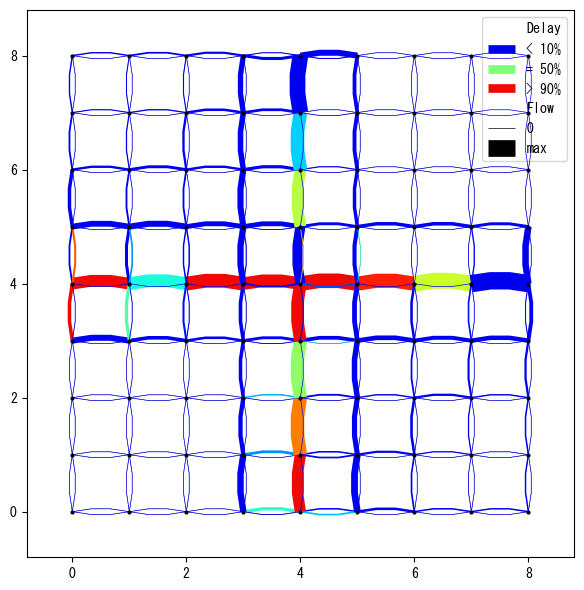

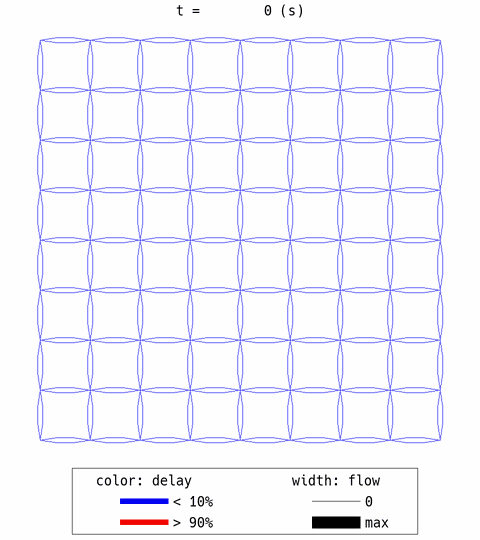

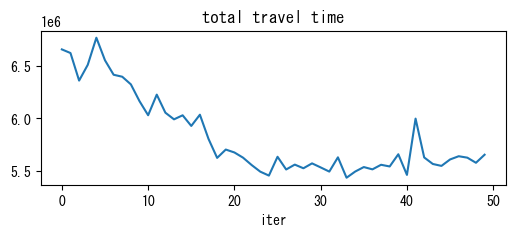

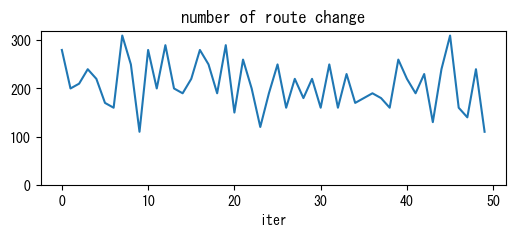

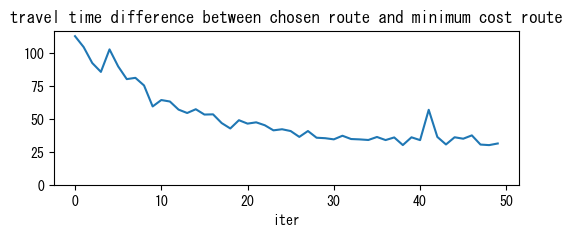

In [21]:
solver_DUE = DTAsolvers.SolverDUE(create_World)
solver_DUE.solve(max_iter=50, n_routes_per_od=20)

W_DUE = solver_DUE.W_sol
W_DUE.analyzer.print_simple_stats(force_print=True)
W_DUE.analyzer.network_average(network_font_size=0, legend=True)
df_DUE = W_DUE.analyzer.basic_to_pandas()

W_DUE.analyzer.network_anim(state_variables="flow_speed", figsize=4, animation_speed_inverse=20, timestep_skip=8, detailed=0, network_font_size=0, file_name="out/anim_DUE.gif")
uxsim.display_image_in_notebook("out/anim_DUE.gif")

solver_DUE.plot_convergence()

The algorithm successfully converged to a steady state, and it can be considered as a quasi-DUE state. 

According to "time gap" coefficient, the DUO solution has about 140 s of time gap. This is the average time difference of route chosen by travelers and the actual minimum cost route. Since travelers in DUO are myopic, it is reasonable to have large time gap value. In the quasi-DUE state, the average time gap was reduced to about 40 s. Travelers are much smarter than DUO. 

In the network animation, you can see that some travelers choose non-central links from the beginning. They anticipated that the central link would be congested and took action to avoid it in advance. 

As a result, the total delay ratio was reduced to about 0.38 from 0.47 of DUO.

However, since travelers in DUE is still selfish, this is not optimal for the entire system.

#### DSO

Now, we compute DSO solution. Note that many local optima exist. It may be required to run the algorithm multiple times to obtain a good result.

simulation setting:
 scenario name: 
 simulation duration:	 4800 s
 number of vehicles:	 6840 veh
 total road length:	 288000 m
 time discret. width:	 10 s
 platoon size:		 10 veh
 number of timesteps:	 480
 number of platoons:	 684
 number of links:	 288
 number of nodes:	 81
 setup time:		 41.51 s
Initial solusion is used
solving DSO by ALNS...
iter: 0 - TTT: 5775700.0, trips:6840/6840, Obj:5775700.0, Best Obj:5775700.0
iter: 20 - TTT: 5876000.0, trips:6840/6840, Obj:5876000.0, Best Obj:5713000.0
iter: 40 - TTT: 5956900.0, trips:6840/6840, Obj:5956900.0, Best Obj:5713000.0
iter: 60 - TTT: 5815300.0, trips:6840/6840, Obj:5815300.0, Best Obj:5713000.0
iter: 80 - TTT: 5424000.0, trips:6840/6840, Obj:5424000.0, Best Obj:5424000.0
iter: 100 - TTT: 5319200.0, trips:6840/6840, Obj:5319200.0, Best Obj:5310400.0
iter: 120 - TTT: 5329200.0, trips:6840/6840, Obj:5329200.0, Best Obj:5264700.0
iter: 140 - TTT: 5240700.0, trips:6840/6840, Obj:5240700.0, Best Obj:5231000.0
iter: 160 - TTT: 5224200.

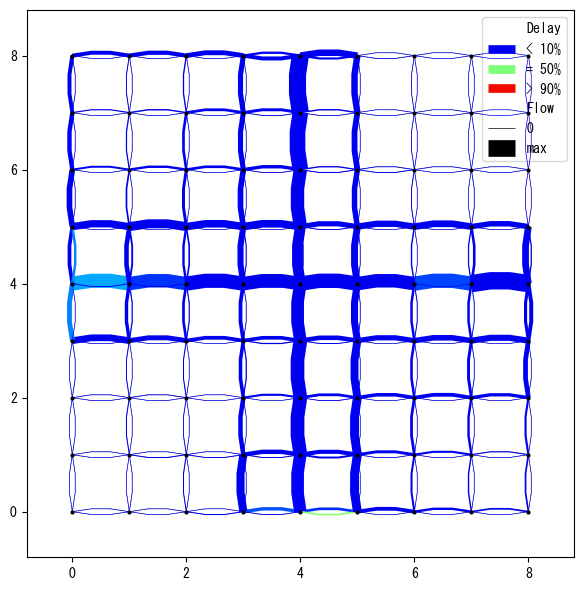

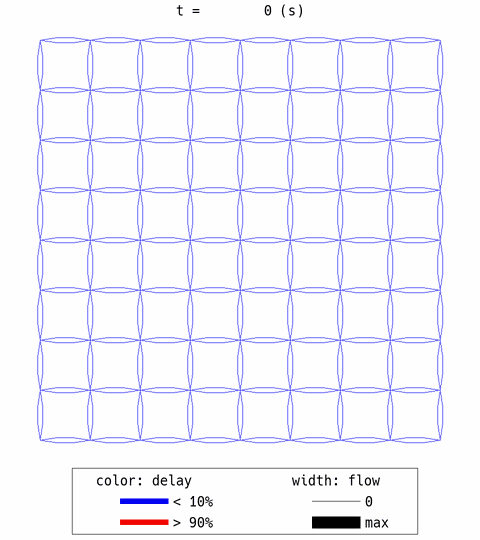

In [24]:
solver_DSO = DTAsolvers.SolverDSO_ALNS(create_World)
solver_DSO.solve(max_iter=500, initial_solution_World=W_DUE)

W_DSO = solver_DSO.W_sol
W_DSO.analyzer.print_simple_stats(force_print=True)
W_DSO.analyzer.network_average(network_font_size=0, legend=True)
df_DSO = W_DSO.analyzer.basic_to_pandas()

W_DSO.analyzer.network_anim(state_variables="flow_speed", figsize=4, animation_speed_inverse=20, timestep_skip=8, detailed=0, network_font_size=0, file_name="out/anim_DSO.gif")
uxsim.display_image_in_notebook("out/anim_DSO.gif")

Now the traffic situation is much better, with 0.31 delay ratio. According to the network animation, traffic was distributed to many routes. Most of traffic congestion observed in DUO/DUE solutions were eliminated.

Below is the summary of the 3 scenarios.

In [25]:
df_DUO['Name'] = 'DUO'
df_DUE['Name'] = 'DUE'
df_DSO['Name'] = 'DSO'

df_combined = pd.concat([df_DUO, df_DUE, df_DSO], ignore_index=True)
cols = ['Name'] + [col for col in df_combined.columns if col != 'Name']
df_combined = df_combined[cols]
display(df_combined)

Name  total_trips  completed_trips  total_travel_time  average_travel_time  \
0  DUO         6840             6840          6663000.0           974.122807   
1  DUE         6840             6840          5651600.0           826.257310   
2  DSO         6840             6840          5100300.0           745.657895   

   total_delay  average_delay  
0    3129000.0     457.456140  
1    2117600.0     309.590643  
2    1566300.0     228.991228

Below is some vehicle-level analysis

In [26]:
travel_time_per_vehicle_duo = [veh.travel_time for veh in W_DUO.VEHICLES.values()]
travel_time_per_vehicle_due = [veh.travel_time for veh in W_DUE.VEHICLES.values()]
travel_time_per_vehicle_dso = [veh.travel_time for veh in W_DSO.VEHICLES.values()]

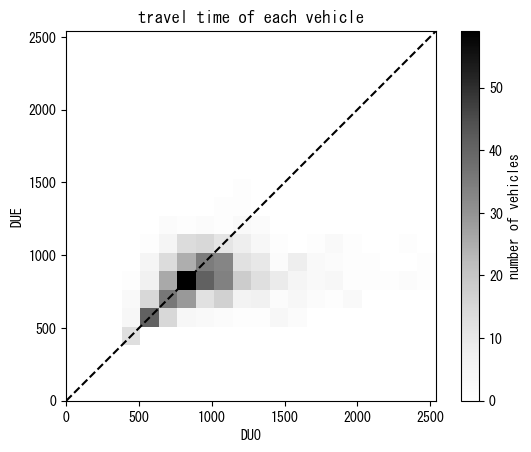

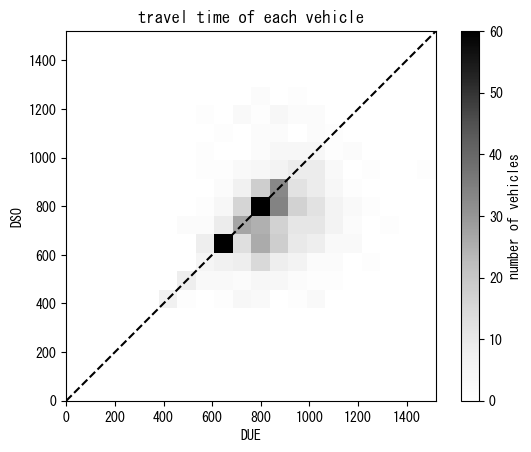

In [27]:
figure()
subplot(111, aspect="equal")
title("travel time of each vehicle")
max_val = max(max(travel_time_per_vehicle_duo), max(travel_time_per_vehicle_due))
plot([0, max_val], [0, max_val], "k--")
hist2d(travel_time_per_vehicle_duo, travel_time_per_vehicle_due, range=[[0, max_val], [0, max_val]], bins=20, cmap="Greys")
colorbar().set_label("number of vehicles")
xlabel("DUO")
ylabel("DUE")
show()

figure()
subplot(111, aspect="equal")
title("travel time of each vehicle")
max_val = max(max(travel_time_per_vehicle_due), max(travel_time_per_vehicle_dso))
plot([0, max_val], [0, max_val], "k--")
hist2d(travel_time_per_vehicle_due, travel_time_per_vehicle_dso, range=[[0, max_val], [0, max_val]], bins=20, cmap="Greys")
colorbar().set_label("number of vehicles")
xlabel("DUE")
ylabel("DSO")
show()

In [28]:
route_of_vehicle_duo = [veh.traveled_route()[0] for veh in W_DUO.VEHICLES.values()]
route_of_vehicle_due = [veh.traveled_route()[0] for veh in W_DUE.VEHICLES.values()]
route_of_vehicle_dso = [veh.traveled_route()[0] for veh in W_DSO.VEHICLES.values()]

In [29]:
print("number of vehicles that choose different routes in different scenarios")

changed = 0
total = 0
for i in lange(route_of_vehicle_duo):
    if route_of_vehicle_duo[i] != route_of_vehicle_due[i]:
        changed += W_DUO.DELTAN
    total += W_DUO.DELTAN
print("DUO vs DUE:", changed, "/", total)

changed = 0
total = 0
for i in lange(route_of_vehicle_duo):
    if route_of_vehicle_due[i] != route_of_vehicle_dso[i]:
        changed += W_DUO.DELTAN
    total += W_DUO.DELTAN
print("DUE vs DSO:", changed, "/", total)

number of vehicles that choose different routes in different scenarios
DUO vs DUE: 5100 / 6840
DUE vs DSO: 2430 / 6840
